In [1]:
import torch
# For dataset preparation
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as TF
# For building neural networks
import torch.nn as nn
import torch.nn.functional as F
# For training
from torch.optim import SGD, Adam
# For visualization
import matplotlib.pyplot as plt

# Preparing the dataset

In [2]:
training_data = datasets.MNIST(
    # Where the data are stored. If this is a relative path, 
    # the path is assumed to start from the current working directory. 
    # Therefore you can find a data folder coming together with this notebook.
    root="./data",  
    train=True, 
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64
training_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

# Defining the model

In [4]:
class AutoencoderCNN(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # To simply the code, let's use Sequential to define the encoder and the decoder,
        # instead of define a  
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(16, 3, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(147, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 147),
            nn.Unflatten(1, (3, 7, 7)),
            nn.ConvTranspose2d(3, 16, 3, stride=2, output_padding=1, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1, padding=1),  
            nn.Sigmoid(),  # for pixel values between 0 and 1
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

In [5]:
# Let's try to check if AutoencoderCNN works

model = AutoencoderCNN(32)
res = model(training_data[0][0].unsqueeze(0))
print(res[0].size())
print(res[1].size())

torch.Size([1, 32])
torch.Size([1, 1, 28, 28])


# Training

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
def train_adam(model, dataloader, lr, epoches):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for epoch in range(epoches):
        model.train()
        for X, Y in dataloader:
            X = X.to(device)
            Y = Y.to(device)
            
            Xhat = model(X)[1]
            loss = criterion(X, Xhat)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        model.eval() 
        with torch.no_grad():
            for X, Y in test_dataloader:
                X = X.to(device)
                Y = Y.to(device)
                
                Xhat = model(X)[1]
                loss = criterion(X, Xhat)

                print(f"epoch {epoch:>3d}   test loss avg: {loss:>5f}")

In [8]:
model = model.to("cuda")
train_adam(model, training_dataloader, lr=0.002, epoches=5)

epoch   0   test loss avg: 0.011581
epoch   1   test loss avg: 0.009270
epoch   2   test loss avg: 0.008535
epoch   3   test loss avg: 0.008072
epoch   4   test loss avg: 0.007777


torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


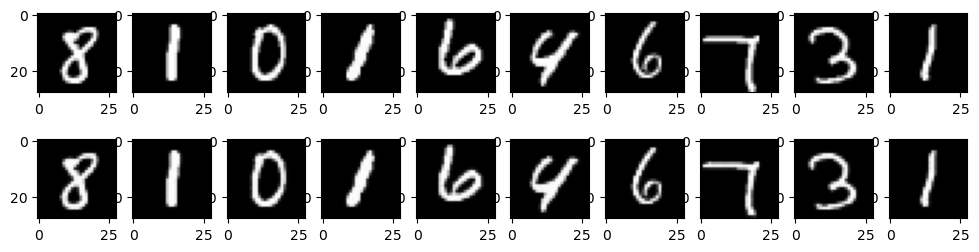

In [9]:
def show_reconstructed_images(model):
    for x, y in test_dataloader:
        break

    x = x.to(device)
    xb = model(x)[1]

    x = x.to("cpu")
    xb = xb.to("cpu")

    print(x.size())
    print(xb.size())

    with torch.no_grad():
        idxs = range(134, 144)
        fig, axes = plt.subplots(2, len(idxs), figsize=(12, 3))
        for i, img_idx in enumerate(idxs):
            axes[0, i].imshow(x[img_idx, 0, :, :], cmap="gray")
            axes[1, i].imshow(xb[img_idx, 0, :, :], cmap="gray")
            
        plt.show()

show_reconstructed_images(model)

torch.Size([10000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


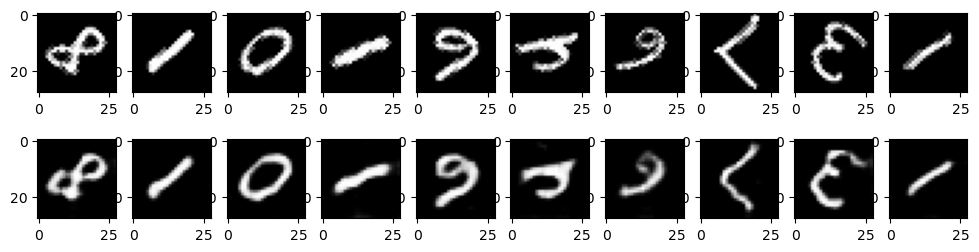

In [9]:
def show_reconstructed_images_rotated(model, angle):
    for x, y in test_dataloader:
        break

    x = TF.rotate(x, angle)
    x = x.to(device)
    xb = model(x)[1]

    x = x.to("cpu")
    xb = xb.to("cpu")

    print(x.size())
    print(xb.size())

    with torch.no_grad():
        idxs = range(134, 144)
        fig, axes = plt.subplots(2, len(idxs), figsize=(12, 3))
        for i, img_idx in enumerate(idxs):
            axes[0, i].imshow(x[img_idx, 0, :, :], cmap="gray")
            axes[1, i].imshow(xb[img_idx, 0, :, :], cmap="gray")
            
        plt.show()

show_reconstructed_images_rotated(model, 135)

# Exploring the structure of the latent space

In [13]:
for x, y in test_dataloader:
    break

x = x.to(device)
y = y.to(device)
z, x_hat = model(x)

In [14]:
z.size()

torch.Size([10000, 32])

The function below selects latent space representation of images of digit `d`.

torch.Size([1135, 32])


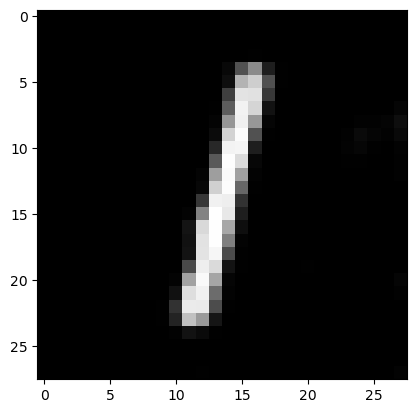

In [27]:
def select_digit(d):
    return z[y == d, :]

print(select_digit(1).size())
# Display the decoding result of the latent space representation of the first sample that represents digit 1
plt.imshow(model.decoder(select_digit(1)[101].unsqueeze(0)).cpu().detach()[0, 0, :, :], cmap="gray")

The code block below shows that the decoding result of the average latent space representation 
of samples that represent sigit 2 also looks like 2.

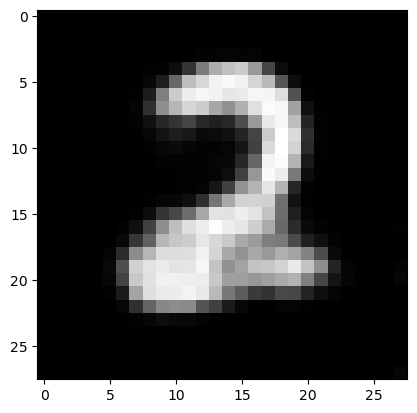

In [31]:
plt.imshow(model.decoder(
        select_digit(2).mean(0).unsqueeze(0)
    ).cpu().detach()[0, 0, :, :], 
cmap="gray")

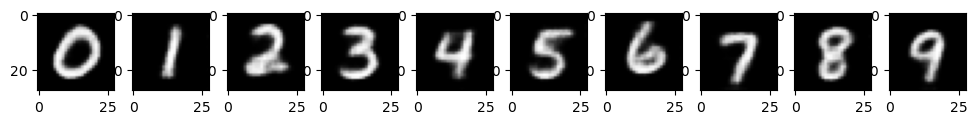

In [35]:
fig, axes = plt.subplots(1, 10, figsize=(12, 1))
for i in range(0, 10):
    axes[i].imshow(model.decoder(
        select_digit(i).mean(0).unsqueeze(0)
    ).cpu().detach()[0, 0, :, :], 
    cmap="gray")

Next, we use tSNE to automatically classify the latent space representations.

In [36]:
from sklearn.manifold import TSNE

It takes less than one minute to finish the tSNE calculation.

In [39]:
z = z.detach().cpu().numpy()
tsne = TSNE(2, random_state=42)
tsne_results = tsne.fit_transform(z)

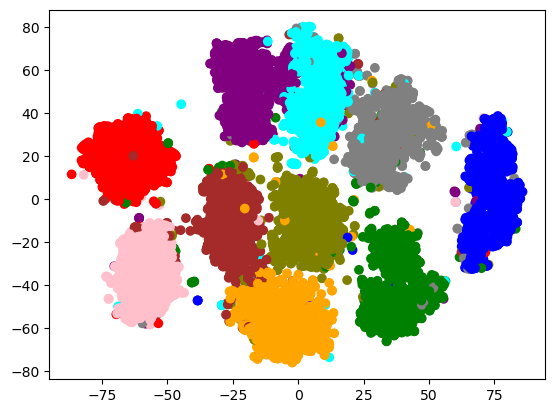

In [52]:
color_map = {
    0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'purple',
    5: 'brown', 6: 'pink', 7: 'gray', 8: 'olive', 9: 'cyan'
}

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=list(map(lambda d: color_map[d], y.cpu().detach().numpy())))